In [1]:
# Setup
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

import matplotlib.pyplot as plt
import numpy as np
mystr = lambda number : "{:.4f}".format(number)

from copy import copy

from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

In [2]:
# Create two consumers, a perfect foresight one and one with shocks to income

# Import standard parameters
from HARK.ConsumptionSaving.ConsumerParameters import init_idiosyncratic_shocks
IdiosyncDict = init_idiosyncratic_shocks

# Make modifications to fit our problem:

# No artificial borrowing constraint
IdiosyncDict["BoroCnstArt"] = -500
# No unemployment
IdiosyncDict["UnempPrb"] = 0
# Ask HARK to compute the value function
IdiosyncDict["vFuncBool"] = True


# Create a copy with income uncertainty turned off
PFDict = copy(IdiosyncDict)
PFDict["PermShkStd"] = [0]
PFDict["TranShkStd"] = [0]

In [3]:
# Create and solve consumers
IndShockConsumer = IndShockConsumerType(**IdiosyncDict)
IndShockConsumer.cycles = 0 # Make this type have an infinite horizon
IndShockConsumer.solve()

PFConsumer = IndShockConsumerType(**PFDict)
PFConsumer.cycles = 0
PFConsumer.solve()

## Figure 1

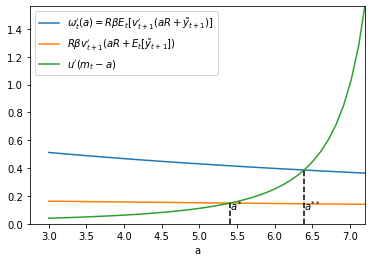

In [4]:
# Figure 1

def uP(agent, c):
    '''
    Computes the marginal utility of consumption for an agent with
    CRRA utility at a consumption level c.
    '''
    return( c**(-agent.CRRA) )
    
def approxOmegaP(agent):
    '''
    Constructs a function that computes the discounted expected marginal value
    of wealth next period w'(a) for a grid of end of period assets using the
    fact that optimal consumption c() satisfies u'(c(m_t)) = w'_t(m_t - c(m_t))
    '''
    # Take the end-of-period assets grid from the consumer
    agrid = agent.aXtraGrid
    a_min = agrid[0]
    a_max = agrid[-1]
    # For each a, we need to find the implied m that generates it
    aux = lambda m: m - agent.solution[0].cFunc(m)
    m_grid = np.array([root_scalar(lambda m: a - aux(m), x0 = a_min, x1 = a_max).root
                       for a in agrid])
    
    # Then we can get consumption
    c_grid = agent.solution[0].cFunc(m_grid)
    # And with consmption, omega, since
    # omega prime is U' at the optimal C.
    omegaP_grid = uP(agent, c_grid)
    
    # We finally interpolate
    omegaP = interp1d(agrid, omegaP_grid, kind='cubic')
    
    return(omegaP)


m = 8
a_min = 3
a_grid = np.linspace(a_min, m*0.99, 50)

# Approximate omega with and without uncertainty
omegaP_uncert = approxOmegaP(IndShockConsumer)
omegaP_PF = approxOmegaP(PFConsumer)

# Find intercepts with marginal utility
a_star1 = root_scalar(lambda a: omegaP_PF(a) - uP(PFConsumer, m - a),
                      bracket = [a_min, m-0.01]).root
a_star2 = root_scalar(lambda a: omegaP_uncert(a) - uP(IndShockConsumer, m - a),
                      bracket = [a_min, m-0.01]).root
                      
# Line labels
lab1 = '$\omega_t\'(a) = R \\beta E_t [v_{t+1}\'(aR + \\tilde{y}_{t+1})]$'
lab2 = '$R \\beta v_{t+1}\'(aR + E_t[\\tilde{y}_{t+1}])$'
lab3 = '$u\'(m_t-a)$'

# Main lines

# Omega uncertainty
plt.figure()
plt.plot(a_grid, omegaP_uncert(a_grid), label = lab1)
# Omega Perfect foresight
plt.plot(a_grid, omegaP_PF(a_grid), label = lab2)
# Marginal utility
plt.plot(a_grid, uP(IndShockConsumer, m - a_grid), label = lab3)

# Intersection lines
plt.plot([a_star1,a_star1],[0,uP(PFConsumer, m - a_star1)],'k--')
plt.text(a_star1,0.1, '$a^*$')
plt.plot([a_star2,a_star2],[0,uP(IndShockConsumer, m - a_star2)],'k--')
plt.text(a_star2,0.1, '$a^{**}$')

plt.ylim(bottom = 0)
plt.xlim(right = m*0.9)
plt.ylim(top = uP(PFConsumer, m - m*0.9))
plt.xlabel('a')
plt.legend()

## Figure 2

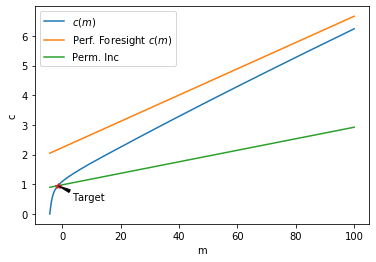

In [5]:
# Figure 2

# Define a function for the delta(m)=0 locus
m0_locus = lambda m: m - (m-1)/(IdiosyncDict["Rfree"]/
                         IdiosyncDict["PermGroFac"][0])

# Define grid of market resources
m_max = 100
m_grid = np.linspace(IndShockConsumer.solution[0].mNrmMin, m_max, 500)

# Main lines

# Uncertainty solution
plt.figure()
plt.plot(m_grid, IndShockConsumer.solution[0].cFunc(m_grid),
         label = '$c(m)$')
# Perfect foresight solution
plt.plot(m_grid, PFConsumer.solution[0].cFunc(m_grid),
         label = 'Perf. Foresight $c(m)$')
# Stable resource line
plt.plot(m_grid, m0_locus(m_grid), label = 'Perm. Inc')
# Target
targ = (IndShockConsumer.solution[0].mNrmSS,
        IndShockConsumer.solution[0].cFunc(IndShockConsumer.solution[0].mNrmSS))
plt.plot(targ[0], targ[1], '*')

# Annotations
plt.xlabel('m')
plt.ylabel('c')
plt.annotate('Target',
             xy = targ,
             xytext = (targ[0]+5, targ[1]-0.5),
             arrowprops=dict(facecolor='black', shrink=0.05,
                             headwidth = 3, width = 0.5))
plt.legend()